# Rekomendasi Unsupervised Lbl2vec

In [2]:
from google_play_scraper import app
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np

from lbl2vec import Lbl2Vec
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import strip_tags
from sklearn.metrics import f1_score
from tqdm import tqdm

tqdm.pandas()

In [3]:
result, continuation_token = reviews(
    'com.dafturn.mypertamina',
    lang='id', 
    country='id', 
    sort=Sort.MOST_RELEVANT, 
    count=114904, 
    filter_score_with=None
)

In [7]:
df = pd.DataFrame.from_dict(result)
df = df[['userName', 'score','at', 'content']]

In [8]:
import re
def cleaningulasan(ulasan):
  ulasan = re.sub(r'@[A-Za-a0-9]+',' ',ulasan)
  ulasan = re.sub(r'#[A-Za-z0-9]+',' ',ulasan)
  ulasan = re.sub(r"http\S+",' ',ulasan)
  ulasan = re.sub(r'[0-9]+',' ',ulasan)
  ulasan = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", ulasan)
  ulasan = ulasan.strip(' ')
  return ulasan

def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')

def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)

def casefoldingText(ulasan):
  ulasan = ulasan.lower()
  return ulasan

In [9]:
df['Cleaning']= df['content'].apply(cleaningulasan)
df['HapusEmoji']= df['Cleaning'].apply(clearEmoji)
df['3/Lebih']= df['HapusEmoji'].apply(replaceTOM)
df['CaseFolding']= df['3/Lebih'].apply(casefoldingText)

In [10]:
def convertToSlangword(ulasan):
    kamusSlang = eval(open("NLP_bahasa_resources\combined_slang_words.txt").read())
    content = []
    for kata in ulasan.split():
        try:
            content.append(kamusSlang[kata])
        except:
            content.append(kata)
    ulasan = ' '.join(content)
    return ulasan

df['Formalisasi'] = df['CaseFolding'].apply(convertToSlangword)

In [32]:
df = pd.read_csv('review_mypertamina_processed.csv')

In [21]:
positive = pd.read_csv('InSet\positive.tsv', sep='\t', index_col='word')
negative = pd.read_csv('InSet\\negative.tsv', sep='\t', index_col='word')

# inset = pd.concat([positive, negative]).to_dict()['weight']
positive = positive.to_dict()['weight']
negative = negative.to_dict()['weight']

In [22]:
def sentiment_score(ulasan):
    inset_positive_score = 0
    inset_negative_score = 0

    for kata in str(ulasan).split():
        try:
            inset_positive_score += positive[kata]
        except:
            inset_positive_score += 0
        
        try:
            inset_negative_score += negative[kata]
        except:
            inset_negative_score += 0

    return inset_positive_score + inset_negative_score

df['sentiment_score'] = df['CaseFolding'].progress_apply(sentiment_score)

100%|██████████| 114904/114904 [00:02<00:00, 44064.64it/s] 


In [34]:
df = df[['userName', 'score','at', 'content', 'Formalisasi', 'sentiment_score']]
df

,userName,score,at,content,Formalisasi,sentiment_score
0,cool_ _id,1,2022-09-11 08:04:14,"Aplikasi ini sangat menyusahkan, baik dari cus...",aplikasi ini sangat menyusahkan baik dari cust...,-36
1,Akun Gmail,1,2022-09-22 09:19:19,dari segi grafik sudah mantep di grafik tinggi...,dari segi grafik sudah mantap di grafik tinggi...,-5
2,Ris Mawardi,1,2022-09-13 00:20:28,Sudah daftar dan sudah isi data lengkap. Katan...,sudah daftar dan sudah isi data lengkap katany...,-13
3,Ali Ms,1,2022-08-31 15:56:00,Sebaiknya bagi yg darah tinggi tidak mendaftar...,sebaiknya bagi yang darah tinggi tidak mendaft...,-17
4,rudy tedjo,1,2022-07-28 11:11:45,"Aplikasi tidak membantu, klik back langsung da...",aplikasi tidak membantu klik back langsung dat...,-17
...,...,...,...,...,...,...
114899,Putra Nainggolan18,1,2022-07-02 12:48:16,abal abal,abal abal,0
114900,Ibnu Khoirul,1,2022-06-30 00:30:34,mumet mumet,pusing pusing,-8
114901,firaz sarw,1,2022-06-30 14:49:17,ruwed ruwed ruwed,ruwed ruwed ruwed,0
114902,Mumtaz Toba,1,2022-06-30 14:03:10,no no no,no no no,0


In [24]:
# df.to_csv('review_mypertamina.csv', index=False)

In [25]:
# df = pd.read_csv('review_mypertamina.csv')

In [35]:
labels = pd.read_csv('label_keyword.csv',sep=';')
labels['keywords'] = labels['keywords'].apply(lambda x: x.lower().split(' '))
labels['number_of_keywords'] = labels['keywords'].apply(lambda row: len(row))

In [36]:
labels

,class_index,class_name,keywords,number_of_keywords
0,1,user_experience,"[menyusahkan, susah, sulit, mempersulit, belum...",11
1,2,jaringan_dan_koneksi,"[sinyal, stabil, wifi, loading, gangguan, jari...",8
2,3,payment,"[pembayaran, payment, linkaja, transfer, bank,...",24
3,4,security,"[data, pribadi, sistem, retas]",4
4,5,akun,"[verifikasi, login, mendaftar, daftar, email, ...",10
5,6,daftar_subsidi,"[subsidi, nik, upload, gagal, perbaiki, memper...",13
6,6,loyalty,"[poin, poinnya, point, pointnya, bonus, vouche...",8
7,7,server,"[server, memori, size, down, ukuran]",5
8,8,invalid_troll,"[war, player, pemain, game, gameplay, lvl, sen...",21


In [37]:
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)

In [29]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score
0,cool_ _id,1,2022-09-11 08:04:14,"Aplikasi ini sangat menyusahkan, baik dari cus...",aplikasi ini sangat menyusahkan baik dari cust...,-54
1,Akun Gmail,1,2022-09-22 09:19:19,dari segi grafik sudah mantep di grafik tinggi...,dari segi grafik sudah mantap di grafik tinggi...,-57
2,Ris Mawardi,1,2022-09-13 00:20:28,Sudah daftar dan sudah isi data lengkap. Katan...,sudah daftar dan sudah isi data lengkap katany...,-31
3,Ali Ms,1,2022-08-31 15:56:00,Sebaiknya bagi yg darah tinggi tidak mendaftar...,sebaiknya bagi yang darah tinggi tidak mendaft...,-37
4,rudy tedjo,1,2022-07-28 11:11:45,"Aplikasi tidak membantu, klik back langsung da...",aplikasi tidak membantu klik back langsung dat...,-27


In [30]:
# sum(df['Formalisasi'].isna())

In [39]:
df['Formalisasi'] = df['Formalisasi'].fillna('').astype(str)
df['tagged_docs'] = df.progress_apply(lambda row: TaggedDocument(tokenize(row['Formalisasi']), [str(row.name)]), axis=1)

C:\Users\ACER\AppData\Local\Temp\ipykernel_11580\2374836411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Formalisasi'] = df['Formalisasi'].fillna('').astype(str)
100%|██████████| 114904/114904 [00:11<00:00, 9927.85it/s] 
C:\Users\ACER\AppData\Local\Temp\ipykernel_11580\2374836411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tagged_docs'] = df.progress_apply(lambda row: TaggedDocument(tokenize(row['Formalisasi']), [str(row.name)]), axis=1)


In [40]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score,tagged_docs
0,cool_ _id,1,2022-09-11 08:04:14,"Aplikasi ini sangat menyusahkan, baik dari cus...",aplikasi ini sangat menyusahkan baik dari cust...,-36,"([aplikasi, ini, sangat, menyusahkan, baik, da..."
1,Akun Gmail,1,2022-09-22 09:19:19,dari segi grafik sudah mantep di grafik tinggi...,dari segi grafik sudah mantap di grafik tinggi...,-5,"([dari, segi, grafik, sudah, mantap, di, grafi..."
2,Ris Mawardi,1,2022-09-13 00:20:28,Sudah daftar dan sudah isi data lengkap. Katan...,sudah daftar dan sudah isi data lengkap katany...,-13,"([sudah, daftar, dan, sudah, isi, data, lengka..."
3,Ali Ms,1,2022-08-31 15:56:00,Sebaiknya bagi yg darah tinggi tidak mendaftar...,sebaiknya bagi yang darah tinggi tidak mendaft...,-17,"([sebaiknya, bagi, yang, darah, tinggi, tidak,..."
4,rudy tedjo,1,2022-07-28 11:11:45,"Aplikasi tidak membantu, klik back langsung da...",aplikasi tidak membantu klik back langsung dat...,-17,"([aplikasi, tidak, membantu, klik, back, langs..."


In [41]:
df['doc_key'] = df.index.astype(str)

C:\Users\ACER\AppData\Local\Temp\ipykernel_11580\3469394351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['doc_key'] = df.index.astype(str)


In [42]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score,tagged_docs,doc_key
0,cool_ _id,1,2022-09-11 08:04:14,"Aplikasi ini sangat menyusahkan, baik dari cus...",aplikasi ini sangat menyusahkan baik dari cust...,-36,"([aplikasi, ini, sangat, menyusahkan, baik, da...",0
1,Akun Gmail,1,2022-09-22 09:19:19,dari segi grafik sudah mantep di grafik tinggi...,dari segi grafik sudah mantap di grafik tinggi...,-5,"([dari, segi, grafik, sudah, mantap, di, grafi...",1
2,Ris Mawardi,1,2022-09-13 00:20:28,Sudah daftar dan sudah isi data lengkap. Katan...,sudah daftar dan sudah isi data lengkap katany...,-13,"([sudah, daftar, dan, sudah, isi, data, lengka...",2
3,Ali Ms,1,2022-08-31 15:56:00,Sebaiknya bagi yg darah tinggi tidak mendaftar...,sebaiknya bagi yang darah tinggi tidak mendaft...,-17,"([sebaiknya, bagi, yang, darah, tinggi, tidak,...",3
4,rudy tedjo,1,2022-07-28 11:11:45,"Aplikasi tidak membantu, klik back langsung da...",aplikasi tidak membantu klik back langsung dat...,-17,"([aplikasi, tidak, membantu, klik, back, langs...",4


In [43]:
doc2vec_model = Doc2Vec(documents=df['tagged_docs'], dbow_words=1, dm=1)

In [44]:
doc2vec_model.save('doc2vec_model')

In [45]:
Lbl2Vec_model = Lbl2Vec(keywords_list=list(labels.keywords),  doc2vec_model=doc2vec_model, label_names=list(labels.class_name), similarity_threshold=0.43, min_num_docs=100, epochs=10)

Lbl2Vec_model.fit()

2022-10-12 21:46:10,096 - Lbl2Vec - INFO - Load document and word embeddings
2022-10-12 21:46:10,101 - Lbl2Vec - INFO - Train label embeddings
2022-10-12 21:46:10,996 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: e-wallet
2022-10-12 21:46:13,319 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: item


In [46]:
model_docs_lbl_similarities = Lbl2Vec_model.predict_model_docs()

2022-10-12 21:46:14,275 - Lbl2Vec - INFO - Get document embeddings from model
2022-10-12 21:46:14,519 - Lbl2Vec - INFO - Calculate document<->label similarities


In [47]:
model_docs_lbl_similarities = model_docs_lbl_similarities.merge(df, left_on='doc_key', right_on='doc_key')#[['content','most_similar_label']]

In [48]:
model_docs_lbl_similarities[['content', 'most_similar_label']]

,content,most_similar_label
0,"Aplikasi ini sangat menyusahkan, baik dari cus...",user_experience
1,dari segi grafik sudah mantep di grafik tinggi...,jaringan_dan_koneksi
2,Sudah daftar dan sudah isi data lengkap. Katan...,security
3,Sebaiknya bagi yg darah tinggi tidak mendaftar...,security
4,"Aplikasi tidak membantu, klik back langsung da...",payment
...,...,...
114899,abal abal,invalid_troll
114900,mumet mumet,invalid_troll
114901,ruwed ruwed ruwed,invalid_troll
114902,no no no,invalid_troll


[Text(0, 0, '7060'),
 Text(0, 0, '4263'),
 Text(0, 0, '3655'),
 Text(0, 0, '3230'),
 Text(0, 0, '2962'),
 Text(0, 0, '1836'),
 Text(0, 0, '1790'),
 Text(0, 0, '1459')]

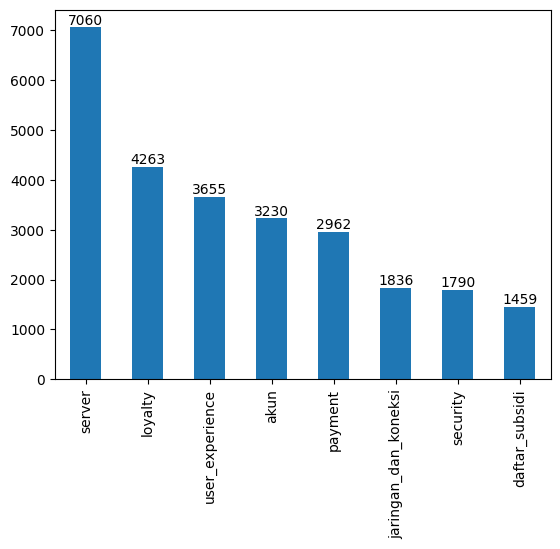

In [49]:
ax = model_docs_lbl_similarities[model_docs_lbl_similarities['most_similar_label'] != 'invalid_troll']['most_similar_label'].value_counts().plot(kind='bar')
ax.bar_label((ax.containers[0]))

In [50]:
sentiment_dict = {}
for i in model_docs_lbl_similarities.iterrows():
    sentiment_dict[i[1]['most_similar_label']] = sentiment_dict.get(i[1]['most_similar_label'], 0) + i[1]['sentiment_score']
    # break

In [51]:
sentiment_df = pd.DataFrame([val for _, val in sentiment_dict.items()], index=sentiment_dict.keys(), columns=['sentiment_score'])

[Text(0, 0, '48481'),
 Text(0, 0, '23236'),
 Text(0, 0, '22680'),
 Text(0, 0, '18084'),
 Text(0, 0, '16846'),
 Text(0, 0, '15633'),
 Text(0, 0, '9060'),
 Text(0, 0, '9007')]

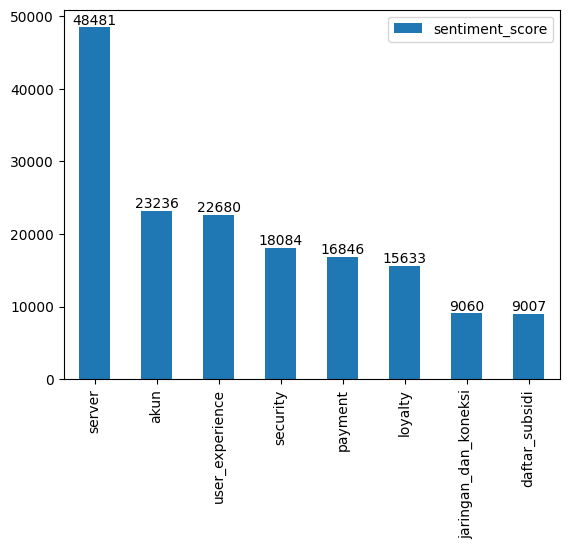

In [52]:
ax = np.abs(sentiment_df.sort_values('sentiment_score'))[1:].plot.bar()
ax.bar_label((ax.containers[0]))

In [53]:
model_docs_lbl_similarities.to_csv('model_docs_lbl_similarities.csv', index=False)

In [54]:
Lbl2Vec_model.save('Lbl2Vec_model')